In [ ]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, make_scorer)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import zscore
import umap
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
os.environ["OMP_NUM_THREADS"] = "2"

In [ ]:
X = pd.read_csv(r'X_gexp.csv').drop(columns=['Unnamed: 0'])
y = pd.read_csv(r'y_gexp.csv').drop(columns=['Unnamed: 0'])
id=X.columns[0]
idy=y.columns[0]
labels = y[y.columns[0]].values

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# Data Inspection

Before proceeding with supervised and unsupervised learning, we performed an exploratory data analysis (EDA) to assess the quality and structure of the dataset.

In [ ]:
# === Dataset dimensions ===
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# === Data types check ===
print("\nData types in X:")
print(X.dtypes.value_counts())

# Check if all columns are numeric
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print(f"\nNumber of non-numeric columns: {len(non_numeric_cols)}")

# === Missing values (NaNs) ===
nans = X.isna().sum()
print(f"\nNumber of columns with NaN values: {(nans > 0).sum()}")

# === Constant columns (no variability) ===
unique_counts = X.nunique()
constant_cols = unique_counts[unique_counts == 1]
print(f"\nNumber of constant columns (no information): {len(constant_cols)}")

# === Outlier detection using z-score ===
z_scores = np.abs(zscore(X, nan_policy='omit'))  # compute absolute z-score
outliers = (z_scores > 3).sum().sum()  # count values with z > 3
print(f"\nTotal number of outlier values (z-score > 3): {outliers}")
print(f"Average number of outliers per feature: {outliers / X.shape[1]:.2f}")

X shape: (302, 5000)
y shape: (302, 1)

Data types in X:
float64    5000
Name: count, dtype: int64

Number of non-numeric columns: 0

Number of columns with NaN values: 0

Number of constant columns (no information): 0

Total number of outlier values (z-score > 3): 14794
Average number of outliers per feature: 2.96



Average skewness across all features: 0.16
Number of features with skewness > 1 (highly right-skewed): 900
Number of features with skewness < -1 (highly left-skewed): 754


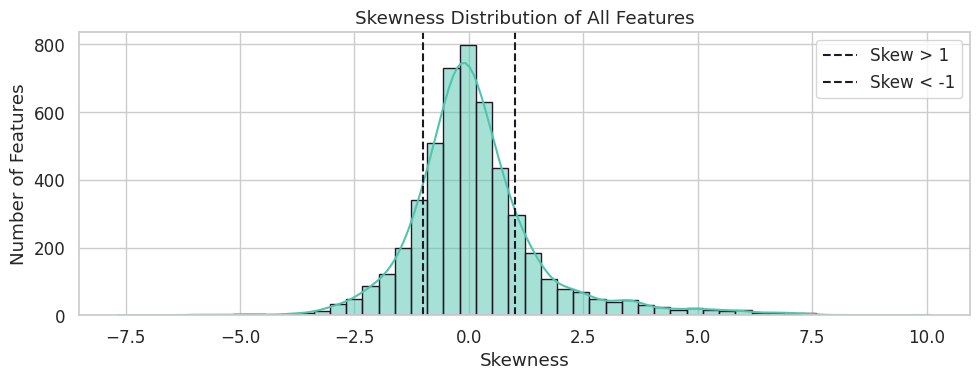


Average variance across all features: 0.0135
Number of features with very low variance (< 1e-5): 0


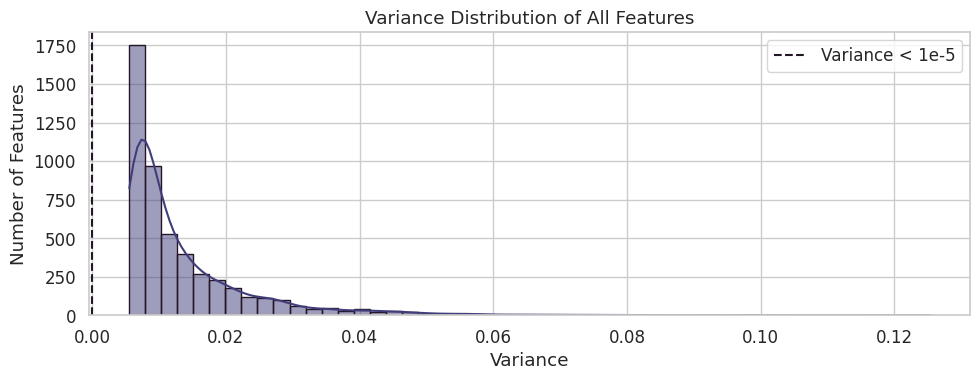

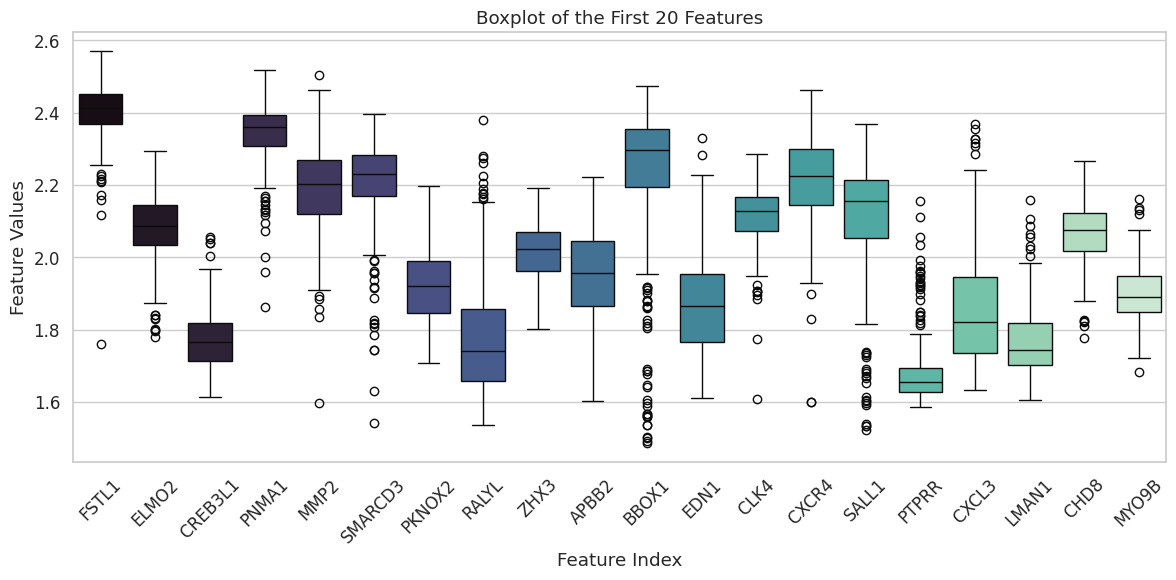

In [ ]:
sns.set(style="whitegrid", font_scale=1.1)
palette = sns.color_palette("mako", 20)
dark_line = palette[1]
green_aqua = palette[5]
blue = palette[15]

# === Skewness analysis ===
skew_vals = X.skew()
print(f"\nAverage skewness across all features: {skew_vals.mean():.2f}")
print(f"Number of features with skewness > 1 (highly right-skewed): {(skew_vals > 1).sum()}")
print(f"Number of features with skewness < -1 (highly left-skewed): {(skew_vals < -1).sum()}")

plt.figure(figsize=(10, 4))
sns.histplot(skew_vals, bins=50, kde=True, color=blue, edgecolor=dark_line)
plt.title('Skewness Distribution of All Features')
plt.xlabel('Skewness')
plt.ylabel('Number of Features')
plt.axvline(1, color= dark_line, linestyle='--', label='Skew > 1')
plt.axvline(-1, color=dark_line, linestyle='--', label='Skew < -1')
plt.legend()
plt.tight_layout()
plt.show()

# === Variance analysis ===
variances = X.var()
print(f"\nAverage variance across all features: {variances.mean():.4f}")
print(f"Number of features with very low variance (< 1e-5): {(variances < 1e-5).sum()}")

plt.figure(figsize=(10, 4))
sns.histplot(variances, bins=50, kde=True, color=green_aqua, edgecolor=dark_line)
plt.title('Variance Distribution of All Features')
plt.xlabel('Variance')
plt.ylabel('Number of Features')
plt.axvline(1e-5, color=dark_line, linestyle='--', label='Variance < 1e-5')
plt.legend()
plt.tight_layout()
plt.show()

# === Boxplot of selected features ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=X.iloc[:, :20], palette=palette)
plt.title('Boxplot of the First 20 Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The dataset consists of 302 samples and 5000 numerical features. All features are numeric, with no missing values or constant columns present. Overall, the features display moderate skewness and generally adequate variance, with no features showing near-zero variance. This suggests the dataset is clean, well-organized, and contains enough variability to support effective discrimination.

# Unsupervised Learning

In the unsupervised analysis, we tested six different approaches. First, we applied K-means and hierarchical clustering on features selected by variance, visualizing the results with PCA. Then, we used PCA as a dimensionality reduction technique and repeated both clustering methods. Finally, we performed the same clustering analyses after applying UMAP for dimensionality reduction. This allowed us to explore how well the intrinsic structure of the gene expression data aligns with the known cancer subtypes.

In [ ]:
clustering_results = []

To evaluate the unsupervised learning methods, we used several clustering validation metrics.

Internal validation metrics, which do not require true labels, include:

* **Silhouette Score:** measures how similar an object is to its own cluster compared to other clusters. Values close to 1 indicate well-separated clusters.

* **Calinski-Harabasz Index:** evaluates cluster separation and compactness; higher values indicate better-defined clusters.

* **Davies-Bouldin Index:** assesses cluster similarity, with lower values meaning more distinct clusters.

To assess how well the clustering corresponds to the known cancer subtypes, we used external validation metrics that compare cluster assignments to true labels:

* **Adjusted Rand Index (ARI):** measures the similarity between clustering results and ground truth, adjusted for chance. Values close to 1 indicate high agreement.

* **Normalized Mutual Information (NMI):** quantifies the shared information between clusters and true labels, with values near 1 indicating strong correspondence.

## Variance Selection

### K-means

In [ ]:
scalers_kmeans = {'standard': StandardScaler(), 'robust': RobustScaler()}
k_features_list_kmeans = [100, 1000]

best_kmeans = {
    'scaler': None,
    'k_features': None,
    'n_clusters': None,
    'top_k_indices': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ STEP 1: GRID SEARCH LOOP ------------------------
for scaler_name_km, scaler_km in scalers_kmeans.items():
    X_scaled_km = scaler_km.fit_transform(X)

    selector_km = VarianceThreshold()
    X_var_km = selector_km.fit_transform(X_scaled_km)
    variances_km = selector_km.variances_

    for k_km in k_features_list_kmeans:
        if X_var_km.shape[1] < k_km:
            continue

        top_k_indices_km = np.argsort(variances_km)[-k_km:]
        X_selected_km = X_var_km[:, top_k_indices_km]

        for n_clusters_km in range(2, 6):
            try:
                kmeans_km = KMeans(n_clusters=n_clusters_km, random_state=seed, n_init='auto')
                clusters_km = kmeans_km.fit_predict(X_selected_km)

                current_scores_km = {
                    'silhouette': silhouette_score(X_selected_km, clusters_km),
                    'calinski': calinski_harabasz_score(X_selected_km, clusters_km),
                    'davies': davies_bouldin_score(X_selected_km, clusters_km)}

                if current_scores_km['silhouette'] > best_kmeans['scores']['silhouette']:
                    best_kmeans.update({
                        'scaler': scaler_name_km,
                        'k_features': k_km,
                        'n_clusters': n_clusters_km,
                        'top_k_indices': top_k_indices_km,
                        'scores': current_scores_km})
            except:
                continue
# ------------------------ STEP 2: PRINT BEST PARAMETERS ------------------------
print("Best params found:")
print(best_kmeans)

# ======================== APPLY BEST PARAMETERS ========================

# ------------------------ STEP 3: FIT BEST CONFIGURATION ------------------------
scaler_km = scalers_kmeans[best_kmeans['scaler']]
X_scaled_km = scaler_km.fit_transform(X)
selector_km = VarianceThreshold()
X_var_km = selector_km.fit_transform(X_scaled_km)
X_selected_km = X_var_km[:, best_kmeans['top_k_indices']]

kmeans_km = KMeans(n_clusters=best_kmeans['n_clusters'], random_state=seed, n_init='auto')
clusters_km = kmeans_km.fit_predict(X_selected_km)

# ------------------------ STEP 4: EVALUATE CLUSTERING ------------------------
sil_km = silhouette_score(X_selected_km, clusters_km)
calinski_km = calinski_harabasz_score(X_selected_km, clusters_km)
davies_km = davies_bouldin_score(X_selected_km, clusters_km)
ari_km = adjusted_rand_score(y[idy].values, clusters_km)
nmi_km = normalized_mutual_info_score(y[idy].values, clusters_km)

print("\nK-means with Variance Feature Selection")
print(f"- Silhouette: {sil_km:.4f}")
print(f"- Calinski-Harabasz: {calinski_km:.4f}")
print(f"- Davies-Bouldin: {davies_km:.4f}")
print("\nEvaluating K-means with Variance Feature Selection with true labels:")
print(f"- ARI: {ari_km:.4f}")
print(f"- NMI: {nmi_km:.4f}")

clustering_results.append({
    'Method': 'KMeans',
    'Reduction': 'Variance Selection',
    'Silhouette': sil_km,
    'Calinski': calinski_km,
    'Davies': davies_km,
    'ARI': ari_km,
    'NMI': nmi_km})


Best params found:
{'scaler': 'robust', 'k_features': 100, 'n_clusters': 2, 'top_k_indices': array([1437, 2009, 1336, 4882, 3341, 1827, 2097, 1231, 4848,  693, 1711,
       3470, 1972, 3284, 4655,  357, 3219, 1494, 1483, 2963, 4970, 1383,
       4476, 3841, 2638, 2043, 4747, 4323, 3879, 4636, 1965, 2070, 3539,
        420, 3216, 4441, 1191, 3094, 3565, 3747, 4375, 1690,  738,  245,
       1951, 2724, 4288, 2937, 4408, 3129, 3287, 3900, 1170,  374, 4525,
       1593, 3680, 4654, 2821, 4884, 3135,  819, 4873, 1544, 1473, 2003,
        934, 3531, 4637, 2449, 2064, 2084, 1216, 1185, 1203, 2444,  482,
        344,  658, 4471, 3570, 1966,  139,  985, 2409,  717, 2920, 3466,
       3015,  204, 1647, 2776, 2137, 4405, 3192, 3141, 3432, 4237, 3997,
       1301]), 'scores': {'silhouette': np.float64(0.8125292616983405), 'calinski': np.float64(334.1705096360763), 'davies': np.float64(0.8519614255697648)}}

K-means with Variance Feature Selection
- Silhouette: 0.8125
- Calinski-Harabasz: 334.1705


Clustering Visualization using PCA

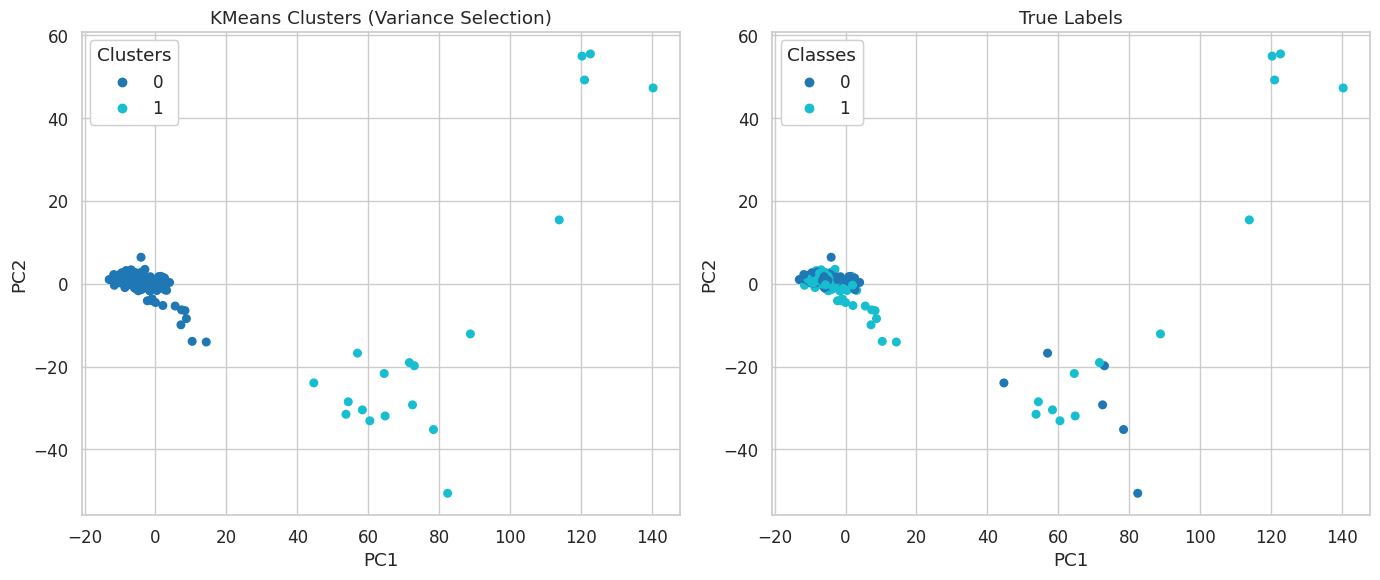

In [ ]:
# ------------------------ STEP 5: CLUSTER SCATTERPLOTS ------------------------
# Apply PCA just for visualization
pca = PCA(n_components=2, random_state=seed)
X_pca_km = pca.fit_transform(X_selected_km)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_pca_km[:, 0], X_pca_km[:, 1], c=clusters_km, cmap='tab10', s=30)
axs[0].set_title("KMeans Clusters (Variance Selection)")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

# True labels
scatter2 = axs[1].scatter(X_pca_km[:, 0], X_pca_km[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)
plt.tight_layout()
plt.show()


### Hierarchical Clustering

In [ ]:
methods = ['ward', 'complete', 'average']
metrics = ['euclidean']
criteria = ['maxclust']
thresholds = range(2, 6)

scalers_hc = {'standard': StandardScaler(), 'robust': RobustScaler()}
k_features_hc = [100, 1000]

best_hierarchical = {
    'scaler': None,
    'k_features': None,
    'method': None,
    'metric': None,
    'criterion': None,
    'threshold': None,
    'top_k_indices': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ STEP 1: GRID SEARCH LOOP ------------------------

for scaler_name_hc, scaler_hc in scalers_hc.items():
    X_scaled_hc = scaler_hc.fit_transform(X)

    selector_hc = VarianceThreshold()
    X_var_hc = selector_hc.fit_transform(X_scaled_hc)
    variances_hc = selector_hc.variances_

    for k_hc in k_features_hc:
        if k_hc > X_var_hc.shape[1]:
            continue

        top_k_indices_hc = np.argsort(variances_hc)[-k_hc:]
        X_selected_hc = X_var_hc[:, top_k_indices_hc]

        for method in methods:
            for metric in metrics:
                for criterion in criteria:
                    try:
                        distance_matrix = pdist(X_selected_hc, metric=metric)
                        Z = linkage(distance_matrix, method=method)

                        for t in thresholds:
                            clusters_hc = fcluster(Z, t=t, criterion=criterion)
                            if len(np.unique(clusters_hc)) < 2:
                                continue

                            current_scores_hc = {
                                'silhouette': silhouette_score(X_selected_hc, clusters_hc),
                                'calinski': calinski_harabasz_score(X_selected_hc, clusters_hc),
                                'davies': davies_bouldin_score(X_selected_hc, clusters_hc)}

                            if current_scores_hc['silhouette'] > best_hierarchical['scores']['silhouette']:
                                best_hierarchical.update({
                                    'scaler': scaler_name_hc,
                                    'k_features': k_hc,
                                    'method': method,
                                    'metric': metric,
                                    'criterion': criterion,
                                    'threshold': t,
                                    'top_k_indices': top_k_indices_hc,
                                    'scores': current_scores_hc})
                    except:
                        continue

# ------------------------ STEP 2: PRINT BEST PARAMETERS ------------------------
print("Best params found:")
print(best_hierarchical)

# ======================== APPLY BEST PARAMETERS ========================

# ------------------------ STEP 3: FIT BEST CONFIGURATION ------------------------
scaler_hc = scalers_hc[best_hierarchical['scaler']]
X_scaled_hc = scaler_hc.fit_transform(X)
selector_hc = VarianceThreshold()
X_var_hc = selector_hc.fit_transform(X_scaled_hc)
X_selected_hc = X_var_hc[:, best_hierarchical['top_k_indices']]

distance_matrix = pdist(X_selected_hc, metric=best_hierarchical['metric'])
Z = linkage(distance_matrix, method=best_hierarchical['method'])
clusters_hc = fcluster(Z, t=best_hierarchical['threshold'], criterion=best_hierarchical['criterion'])

# ------------------------ STEP 4: EVALUATE CLUSTERING ------------------------
sil_hc = silhouette_score(X_selected_hc, clusters_hc)
calinski_hc = calinski_harabasz_score(X_selected_hc, clusters_hc)
davies_hc = davies_bouldin_score(X_selected_hc, clusters_hc)
ari_hc = adjusted_rand_score(y[idy].values, clusters_hc)
nmi_hc = normalized_mutual_info_score(y[idy].values, clusters_hc)

print("\nHierarchical Clustering with Variance Feature Selection:")
print(f"- Silhouette: {sil_hc:.4f}")
print(f"- Calinski-Harabasz: {calinski_hc:.4f}")
print(f"- Davies-Bouldin: {davies_hc:.4f}")
print("\nEvaluating Hierarchical Clustering with Variance Feature Selection with true labels:")
print(f"- ARI: {ari_hc:.4f}")
print(f"- NMI: {nmi_hc:.4f}")

clustering_results.append({
    'Method': 'Hierarchical',
    'Reduction': 'Variance Selection',
    'Silhouette': sil_hc,
    'Calinski': calinski_hc,
    'Davies': davies_hc,
    'ARI': ari_hc,
    'NMI': nmi_hc})


Best params found:
{'scaler': 'robust', 'k_features': 100, 'method': 'complete', 'metric': 'euclidean', 'criterion': 'maxclust', 'threshold': 2, 'top_k_indices': array([1437, 2009, 1336, 4882, 3341, 1827, 2097, 1231, 4848,  693, 1711,
       3470, 1972, 3284, 4655,  357, 3219, 1494, 1483, 2963, 4970, 1383,
       4476, 3841, 2638, 2043, 4747, 4323, 3879, 4636, 1965, 2070, 3539,
        420, 3216, 4441, 1191, 3094, 3565, 3747, 4375, 1690,  738,  245,
       1951, 2724, 4288, 2937, 4408, 3129, 3287, 3900, 1170,  374, 4525,
       1593, 3680, 4654, 2821, 4884, 3135,  819, 4873, 1544, 1473, 2003,
        934, 3531, 4637, 2449, 2064, 2084, 1216, 1185, 1203, 2444,  482,
        344,  658, 4471, 3570, 1966,  139,  985, 2409,  717, 2920, 3466,
       3015,  204, 1647, 2776, 2137, 4405, 3192, 3141, 3432, 4237, 3997,
       1301]), 'scores': {'silhouette': np.float64(0.8305270132956242), 'calinski': np.float64(156.2228460509277), 'davies': np.float64(0.38809900020871957)}}

Hierarchical Clusteri

Clustering Visualization using PCA

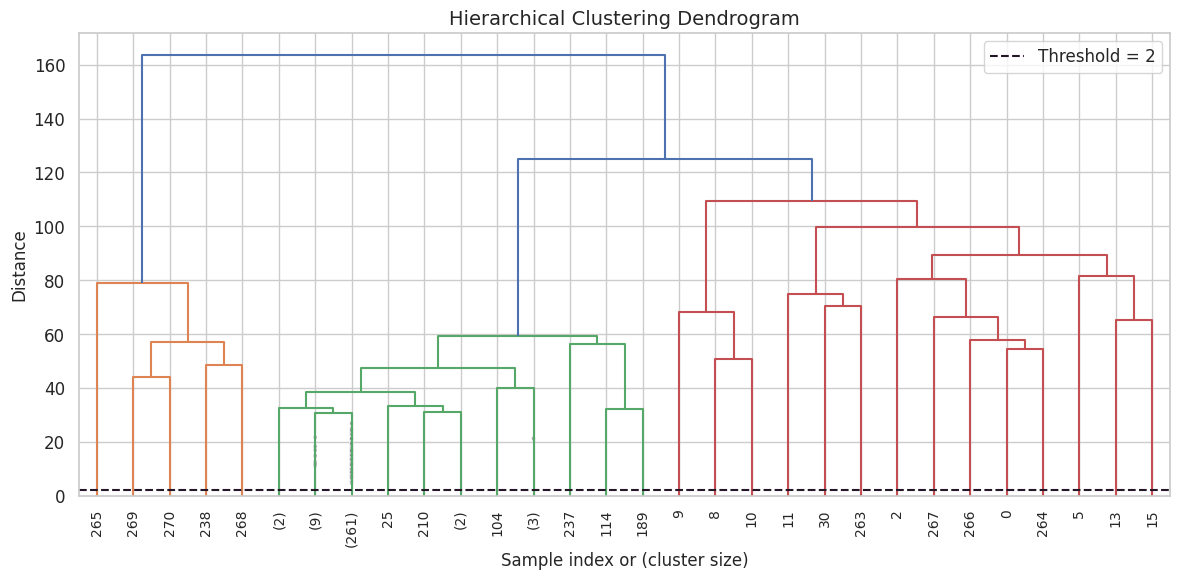

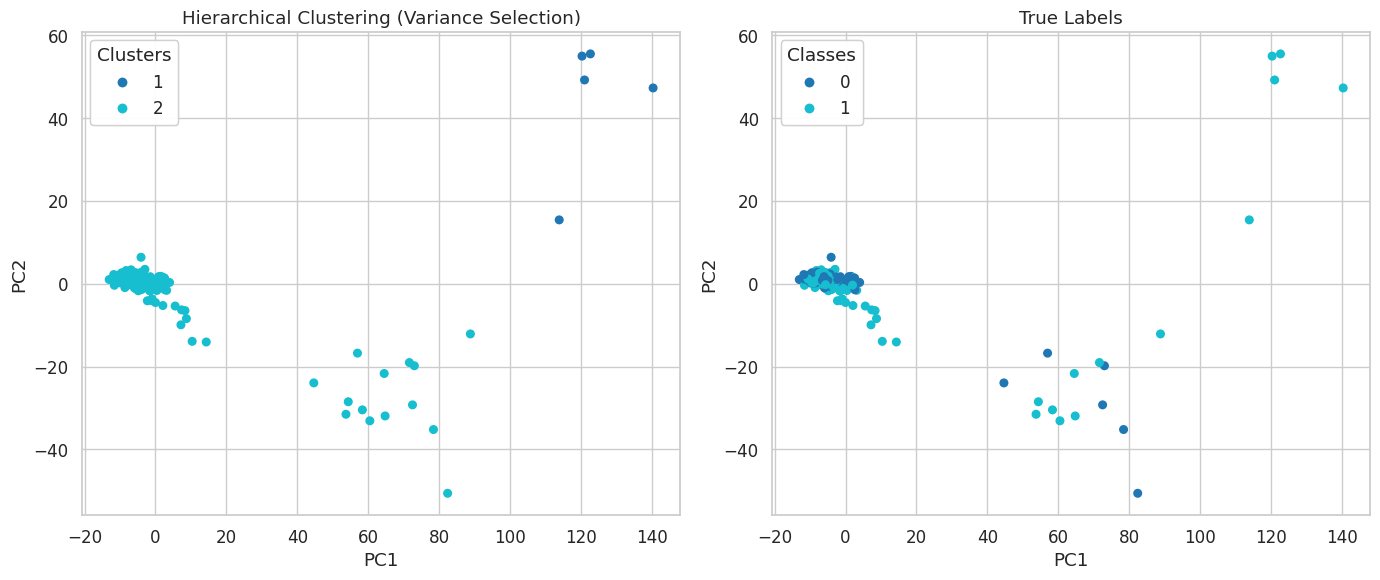

In [ ]:
# ------------------------ STEP 5: DENDROGRAM ------------------------
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram", fontsize=14)
dendrogram(Z,truncate_mode="lastp", p=30,leaf_rotation=90.,leaf_font_size=10.,show_contracted=True)
plt.axhline(y=best_hierarchical['threshold'],color=dark_line, linestyle='--',label=f'Threshold = {best_hierarchical["threshold"]}')
plt.xlabel("Sample index or (cluster size)", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ STEP 6: CLUSTER SCATTERPLOTS ------------------------
# Apply PCA just for visualization
pca_hc = PCA(n_components=2, random_state=seed)
X_pca_hc = pca_hc.fit_transform(X_selected_hc)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_pca_hc[:, 0], X_pca_hc[:, 1], c=clusters_hc, cmap='tab10', s=30)
axs[0].set_title("Hierarchical Clustering (Variance Selection)")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

# True labels
scatter2 = axs[1].scatter(X_pca_hc[:, 0], X_pca_hc[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)
plt.tight_layout()
plt.show()


## PCA

### K-means

In [ ]:
scalers = {'standard': StandardScaler(), 'robust': RobustScaler()}
best_kmeans_params = {
    'scaler': None,
    'n_components': None,
    'n_clusters': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ STEP 1: GRID SEARCH LOOP ------------------------
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)  # apenas normalização

    for n_components in range(2, min(X_scaled.shape[1], 50), 5):
        pca = PCA(n_components=n_components, random_state=seed)
        X_pca = pca.fit_transform(X_scaled)

        for n_clusters in range(2, 5):
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
                clusters = kmeans.fit_predict(X_pca)

                current_scores = {
                    'silhouette': silhouette_score(X_pca, clusters),
                    'calinski': calinski_harabasz_score(X_pca, clusters),
                    'davies': davies_bouldin_score(X_pca, clusters)}

                if current_scores['silhouette'] > best_kmeans_params['scores']['silhouette']:
                    best_kmeans_params.update({
                        'scaler': scaler_name,
                        'n_components': n_components,
                        'n_clusters': n_clusters,
                        'scores': current_scores})
            except Exception:
                continue
# ------------------------ STEP 2: PRINT BEST PARAMETERS ------------------------
print("Best params found:")
print(best_kmeans_params)

# ======================== APPLY BEST PARAMETERS ========================

# ------------------------ STEP 3: FIT BEST CONFIGURATION ------------------------
scaler = StandardScaler() if best_kmeans_params['scaler'] == 'standard' else RobustScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=best_kmeans_params['n_components'], random_state=seed)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=best_kmeans_params['n_clusters'], random_state=seed, n_init='auto')
clusters = kmeans.fit_predict(X_pca)

# ------------------------ STEP 4: EVALUATE CLUSTERING ------------------------
sil_score = silhouette_score(X_pca, clusters)
calinski_score = calinski_harabasz_score(X_pca, clusters)
davies_score = davies_bouldin_score(X_pca, clusters)
ari = adjusted_rand_score(y[idy].values, clusters)
nmi = normalized_mutual_info_score(y[idy].values, clusters)

print("\nClustering metrics for k-means with PCA:")
print(f"- Silhouette Score: {sil_score:.4f}")
print(f"- Calinski-Harabasz Index: {calinski_score:.4f}")
print(f"- Davies-Bouldin Index: {davies_score:.4f}")

print("\nEvaluating k-means with PCA with true labels:")
print(f"- Adjusted Rand Index (ARI): {ari:.4f}")
print(f"- Normalized Mutual Information (NMI): {nmi:.4f}")

clustering_results.append({
    'Method': 'KMeans',
    'Reduction': 'PCA',
    'Silhouette': sil_score,
    'Calinski': calinski_score,
    'Davies': davies_score,
    'ARI': ari,
    'NMI': nmi})

Best params found:
{'scaler': 'robust', 'n_components': 2, 'n_clusters': 2, 'scores': {'silhouette': np.float64(0.7612767105981739), 'calinski': np.float64(416.12872167817386), 'davies': np.float64(0.4360740219145637)}}

Clustering metrics for k-means with PCA:
- Silhouette Score: 0.7613
- Calinski-Harabasz Index: 416.1287
- Davies-Bouldin Index: 0.4361

Evaluating k-means with PCA with true labels:
- Adjusted Rand Index (ARI): -0.0019
- Normalized Mutual Information (NMI): 0.0080


Clustering Visualizations

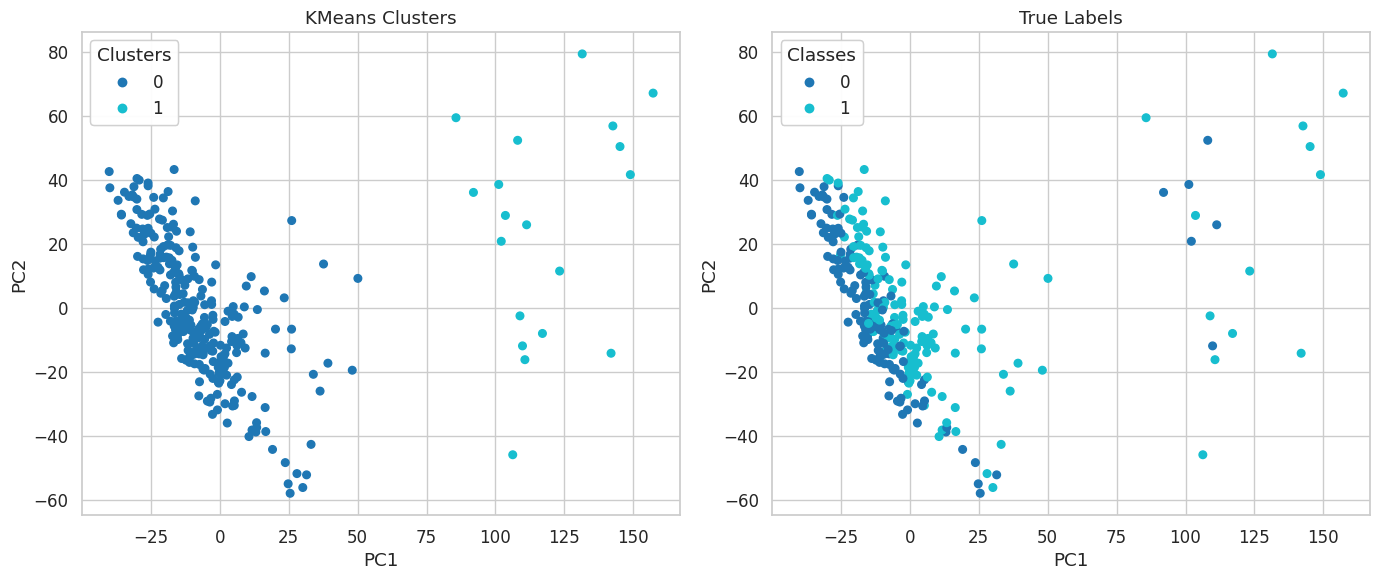

In [ ]:
# ------------------------ STEP 5: CLUSTER SCATTERPLOTS ------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=30)
axs[0].set_title("KMeans Clusters")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

# True labels
scatter2 = axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)
plt.tight_layout()
plt.show()

### Hierarchical Clustering

In [ ]:
scalers = {'standard': StandardScaler(), 'robust': RobustScaler()}
methods = ['ward', 'complete']
metrics = ['euclidean']
criteria = ['maxclust']
thresholds = range(2, 5)

best_hier_params = {
    'scaler': None,
    'n_components': None,
    'threshold': None,
    'method': None,
    'metric': None,
    'criterion': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ STEP 1: GRID SEARCH LOOP ------------------------
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)  # apenas normalização

    for n_components in range(2, min(X_scaled.shape[1], 50), 5):
        pca = PCA(n_components=n_components, random_state=seed)
        X_pca = pca.fit_transform(X_scaled)

        for method in methods:
            for metric in metrics:
                for criterion in criteria:
                    try:
                        distance_matrix = pdist(X_pca, metric=metric)
                        Z = linkage(distance_matrix, method=method)

                        for t in thresholds:
                            clusters = fcluster(Z, t=t, criterion=criterion)
                            if len(np.unique(clusters)) < 2:
                                continue

                            current_scores = {
                                'silhouette': silhouette_score(X_pca, clusters),
                                'calinski': calinski_harabasz_score(X_pca, clusters),
                                'davies': davies_bouldin_score(X_pca, clusters)}

                            if current_scores['silhouette'] > best_hier_params['scores']['silhouette']:
                                best_hier_params.update({
                                    'scaler': scaler_name,
                                    'n_components': n_components,
                                    'threshold': t,
                                    'method': method,
                                    'metric': metric,
                                    'criterion': criterion,
                                    'scores': current_scores})
                    except Exception:
                        continue

# ------------------------ STEP 2: PRINT BEST PARAMETERS ------------------------
print("Best params found:")
print(best_hier_params)

# ------------------------ STEP 3: FIT BEST CONFIGURATION ------------------------
scaler = StandardScaler() if best_hier_params['scaler'] == 'standard' else RobustScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=best_hier_params['n_components'], random_state=seed)
X_pca = pca.fit_transform(X_scaled)

distance_matrix = pdist(X_pca, metric=best_hier_params['metric'])
Z = linkage(distance_matrix, method=best_hier_params['method'])
clusters = fcluster(Z, t=best_hier_params['threshold'], criterion=best_hier_params['criterion'])

# ------------------------ STEP 4: EVALUATE CLUSTERING ------------------------
sil_score = silhouette_score(X_pca, clusters)
calinski_score = calinski_harabasz_score(X_pca, clusters)
davies_score = davies_bouldin_score(X_pca, clusters)
ari = adjusted_rand_score(y[idy].values, clusters)
nmi = normalized_mutual_info_score(y[idy].values, clusters)

print("\nClustering metrics for Hierarchical Clustering with PCA:")
print(f"- Silhouette Score: {sil_score:.4f}")
print(f"- Calinski-Harabasz Index: {calinski_score:.4f}")
print(f"- Davies-Bouldin Index: {davies_score:.4f}")

print("\nEvaluating Hierarchical Clustering with PCA with true labels:")
print(f"- Adjusted Rand Index (ARI): {ari:.4f}")
print(f"- Normalized Mutual Information (NMI): {nmi:.4f}")

clustering_results.append({
    'Method': 'Hierarchical',
    'Reduction': 'PCA',
    'Silhouette': sil_score,
    'Calinski': calinski_score,
    'Davies': davies_score,
    'ARI': ari,
    'NMI': nmi})

Best params found:
{'scaler': 'robust', 'n_components': 2, 'threshold': 2, 'method': 'ward', 'metric': 'euclidean', 'criterion': 'maxclust', 'scores': {'silhouette': np.float64(0.7612767105981739), 'calinski': np.float64(416.12872167817386), 'davies': np.float64(0.4360740219145637)}}

Clustering metrics for Hierarchical Clustering with PCA:
- Silhouette Score: 0.7613
- Calinski-Harabasz Index: 416.1287
- Davies-Bouldin Index: 0.4361

Evaluating Hierarchical Clustering with PCA with true labels:
- Adjusted Rand Index (ARI): -0.0019
- Normalized Mutual Information (NMI): 0.0080


Clustering Visualizations

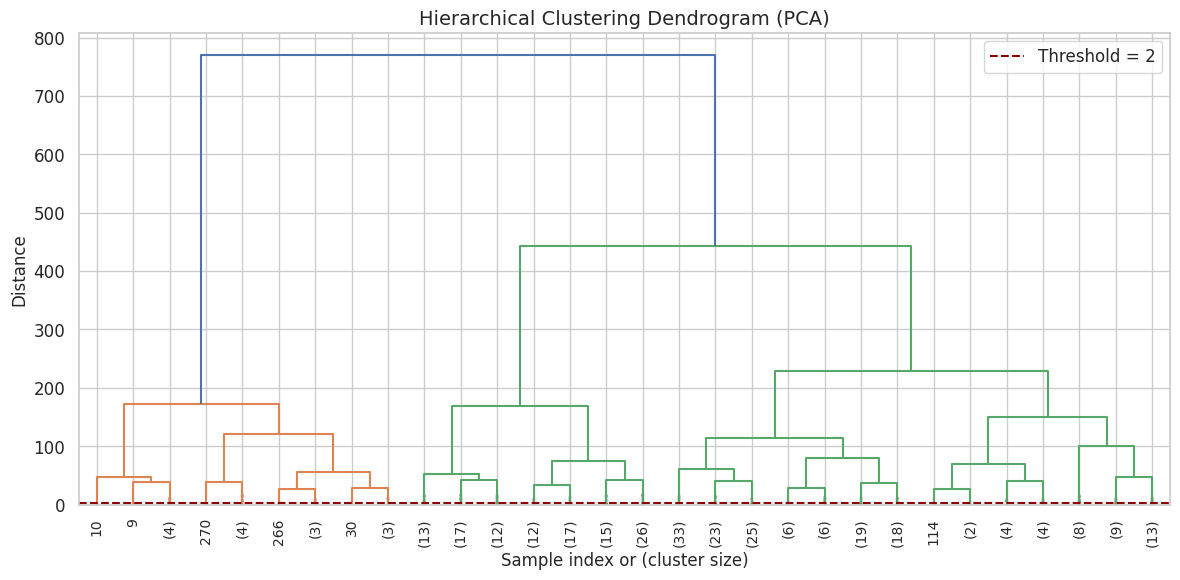

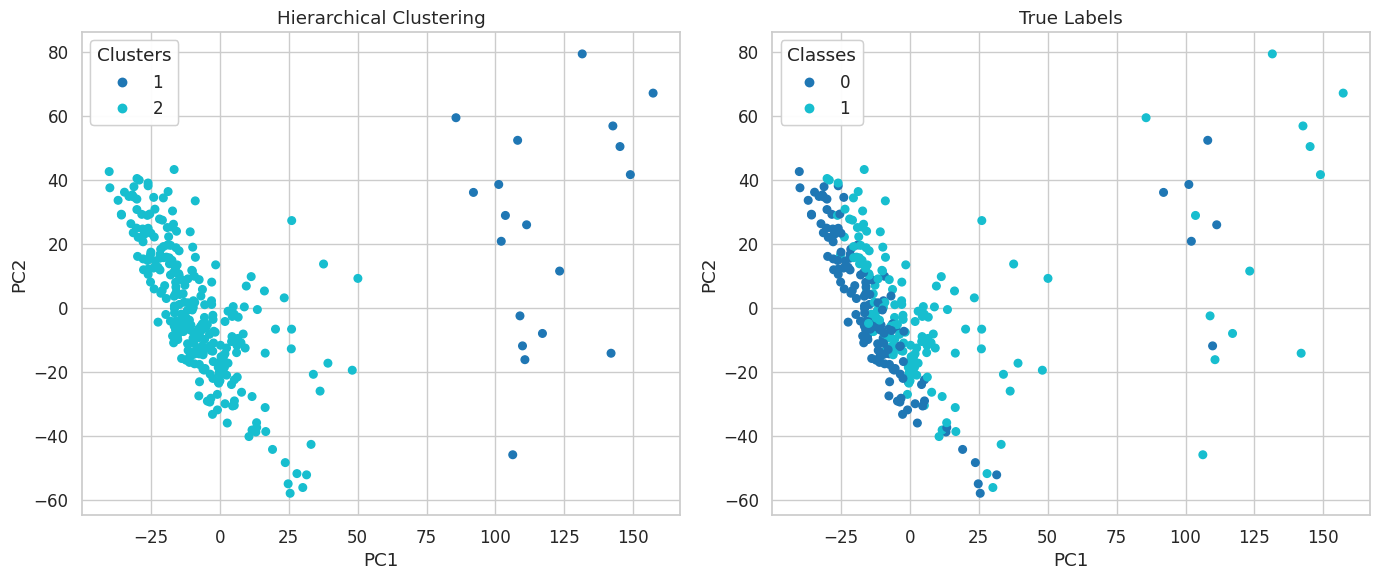

In [ ]:
# ------------------------ STEP 5: DENDROGRAM ------------------------
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram (PCA)", fontsize=14)
dendrogram(Z,truncate_mode="lastp",p=30,leaf_rotation=90.,leaf_font_size=10.,show_contracted=True)
plt.axhline(y=best_hier_params['threshold'],color='darkred', linestyle='--',label=f'Threshold = {best_hier_params["threshold"]}')
plt.xlabel("Sample index or (cluster size)", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ STEP 6: CLUSTER SCATTERPLOTS ------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=30)
axs[0].set_title("Hierarchical Clustering")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

# True labels
scatter2 = axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)
plt.tight_layout()
plt.show()

## UMAP

### K-means

In [ ]:
scalers = {'standard': StandardScaler(),'robust': RobustScaler()}

n_clusters_list = range(2, 6)
n_umap_components = range(2, 21, 4)

best_umap_kmeans_params = {
    'scaler': None,
    'n_components': None,
    'n_clusters': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ GRID SEARCH ------------------------
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)

    for n_components in n_umap_components:
        reducer = umap.UMAP(n_components=n_components, random_state=seed)
        X_umap = reducer.fit_transform(X_scaled)

        for n_clusters in n_clusters_list:
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
                clusters = kmeans.fit_predict(X_umap)

                current_scores = {
                    'silhouette': silhouette_score(X_umap, clusters),
                    'calinski': calinski_harabasz_score(X_umap, clusters),
                    'davies': davies_bouldin_score(X_umap, clusters)}

                if current_scores['silhouette'] > best_umap_kmeans_params['scores']['silhouette']:
                    best_umap_kmeans_params.update({
                        'scaler': scaler_name,
                        'n_components': n_components,
                        'n_clusters': n_clusters,
                        'scores': current_scores})
            except:
                continue

# ------------------------ PRINT BEST PARAMETERS ------------------------
print("Best UMAP-KMeans parameters found:")
print(best_umap_kmeans_params)

# ------------------------ FIT BEST CONFIGURATION ------------------------
scaler = scalers[best_umap_kmeans_params['scaler']]
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(n_components=best_umap_kmeans_params['n_components'], random_state=seed)
X_umap = reducer.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=best_umap_kmeans_params['n_clusters'], random_state=seed, n_init='auto')
clusters = kmeans.fit_predict(X_umap)

# ------------------------ EVALUATE CLUSTERING ------------------------
sil_score = silhouette_score(X_umap, clusters)
calinski_score = calinski_harabasz_score(X_umap, clusters)
davies_score = davies_bouldin_score(X_umap, clusters)
ari = adjusted_rand_score(y[idy].values, clusters)
nmi = normalized_mutual_info_score(y[idy].values, clusters)

print("\nClustering metrics for KMeans with UMAP:")
print(f"- Silhouette Score: {sil_score:.4f}")
print(f"- Calinski-Harabasz Index: {calinski_score:.4f}")
print(f"- Davies-Bouldin Index: {davies_score:.4f}")

print("\nEvaluating KMeans with UMAP against true labels:")
print(f"- Adjusted Rand Index (ARI): {ari:.4f}")
print(f"- Normalized Mutual Information (NMI): {nmi:.4f}")

clustering_results.append({
    'Method': 'KMeans',
    'Reduction': 'UMAP',
    'Silhouette': sil_score,
    'Calinski': calinski_score,
    'Davies': davies_score,
    'ARI': ari,
    'NMI': nmi})


Best UMAP-KMeans parameters found:
{'scaler': 'standard', 'n_components': 14, 'n_clusters': 2, 'scores': {'silhouette': np.float32(0.49103692), 'calinski': np.float32(351.89334), 'davies': np.float64(0.7138067745892382)}}

Clustering metrics for KMeans with UMAP:
- Silhouette Score: 0.4910
- Calinski-Harabasz Index: 351.8933
- Davies-Bouldin Index: 0.7138

Evaluating KMeans with UMAP against true labels:
- Adjusted Rand Index (ARI): 0.0069
- Normalized Mutual Information (NMI): 0.0064


Clustering Visualizations

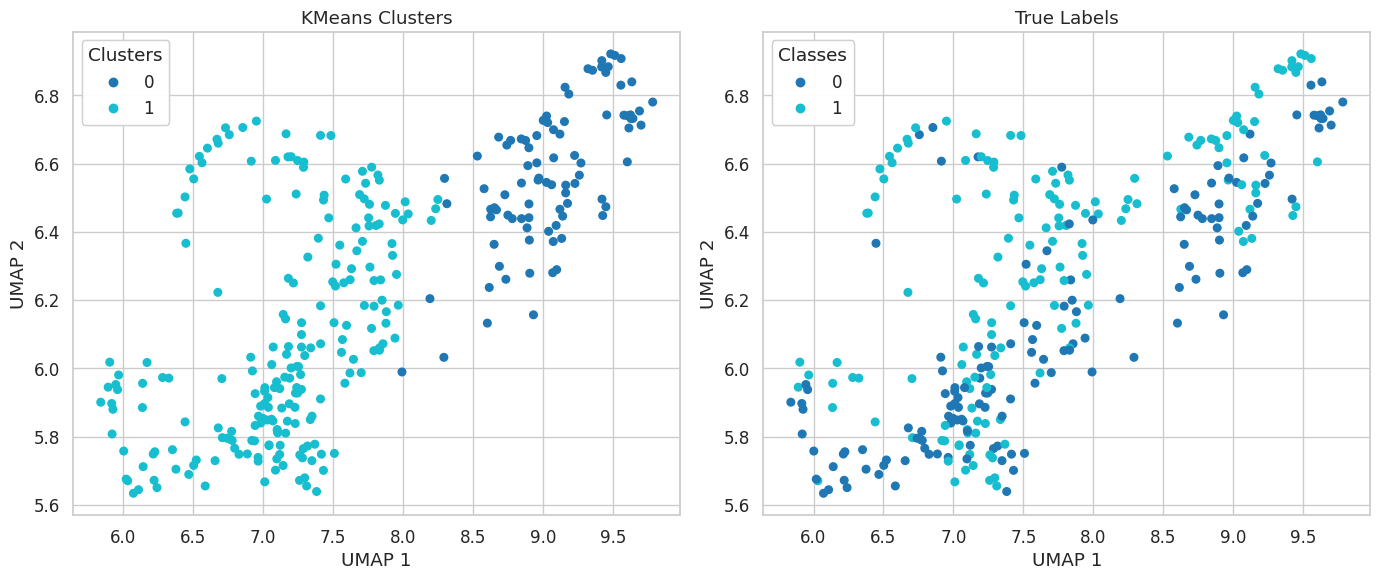

In [ ]:
# ------------------------ STEP 5: CLUSTER SCATTERPLOTS ------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# predicted clusters
scatter1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab10', s=30)
axs[0].set_title("KMeans Clusters")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

# true labels
scatter2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)

plt.tight_layout()
plt.show()

### Hierarchical Clustering

In [ ]:
# define grid search parameters
methods = ['ward', 'complete', 'average']
metrics = ['euclidean']
criteria = ['maxclust']
thresholds = range(2, 6)
n_umap_components = range(2, 21, 2)
scalers = {'standard': StandardScaler(),'robust': RobustScaler()}

# structure to store best parameters and best scores
best_params = {
    'scaler': None,
    'n_components': None,
    'method': None,
    'metric': None,
    'criterion': None,
    'threshold': None,
    'scores': {
        'silhouette': -1,
        'calinski': -1,
        'davies': float('inf')}}

# ------------------------ STEP 1: GRID SEARCH LOOP ------------------------
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)

    for n_components in n_umap_components:
        reducer = umap.UMAP(n_components=n_components, random_state=seed)
        X_umap = reducer.fit_transform(X_scaled)

        for method in methods:
            for metric in metrics:
                for criterion in criteria:
                    try:
                        distance_matrix = pdist(X_umap, metric=metric)
                        Z = linkage(distance_matrix, method=method)

                        for t in thresholds:
                            clusters = fcluster(Z, t=t, criterion=criterion)

                            if len(np.unique(clusters)) < 2:
                                continue

                            current_scores = {
                                'silhouette': silhouette_score(X_umap, clusters),
                                'calinski': calinski_harabasz_score(X_umap, clusters),
                                'davies': davies_bouldin_score(X_umap, clusters)}

                            if current_scores['silhouette'] > best_params['scores']['silhouette']:
                                best_params.update({
                                    'scaler': scaler_name,
                                    'n_components': n_components,
                                    'method': method,
                                    'metric': metric,
                                    'criterion': criterion,
                                    'threshold': t,
                                    'scores': current_scores})
                    except Exception:
                        continue

# ------------------------ STEP 2: PRINT BEST PARAMETERS ------------------------
print("\nBest Parameters Found:")
print(f"- Scaler: {best_params['scaler']}")
print(f"- UMAP Components: {best_params['n_components']}")
print(f"- Linkage Method: {best_params['method']}")
print(f"- Distance Metric: {best_params['metric']}")
print(f"- Criterion: {best_params['criterion']}")
print(f"- Threshold: {best_params['threshold']}")

# ======================== APPLY BEST PARAMETERS ========================

# ------------------------ STEP 3: FIT BEST CONFIGURATION ------------------------
scaler = scalers[best_params['scaler']]
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(n_components=best_params['n_components'], random_state=seed)
X_umap = reducer.fit_transform(X_scaled)

distance_matrix = pdist(X_umap, metric=best_params['metric'])
Z = linkage(distance_matrix, method=best_params['method'])
clusters = fcluster(Z, t=best_params['threshold'], criterion=best_params['criterion'])

# ------------------------ STEP 4: EVALUATE CLUSTERING ------------------------
sil_score = silhouette_score(X_umap, clusters)
calinski_score = calinski_harabasz_score(X_umap, clusters)
davies_score = davies_bouldin_score(X_umap, clusters)
ari = adjusted_rand_score(y[idy].values, clusters)
nmi = normalized_mutual_info_score(y[idy].values, clusters)

print("\nClustering metrics for Hierarchical Clustering with UMAP:")
print(f"- Silhouette Score: {sil_score:.4f}")
print(f"- Calinski-Harabasz Index: {calinski_score:.4f}")
print(f"- Davies-Bouldin Index: {davies_score:.4f}")

print("\nEvaluating Hierarchical Clustering with UMAP with true labels:")
print(f"- Adjusted Rand Index (ARI): {ari:.4f}")
print(f"- Normalized Mutual Information (NMI): {nmi:.4f}")

clustering_results.append({
    'Method': 'Hierarchical',
    'Reduction': 'UMAP',
    'Silhouette': sil_score,
    'Calinski': calinski_score,
    'Davies': davies_score,
    'ARI': ari,
    'NMI': nmi})



Best Parameters Found:
- Scaler: standard
- UMAP Components: 4
- Linkage Method: complete
- Distance Metric: euclidean
- Criterion: maxclust
- Threshold: 2

Clustering metrics for Hierarchical Clustering with UMAP:
- Silhouette Score: 0.4971
- Calinski-Harabasz Index: 352.6044
- Davies-Bouldin Index: 0.6931

Evaluating Hierarchical Clustering with UMAP with true labels:
- Adjusted Rand Index (ARI): 0.0056
- Normalized Mutual Information (NMI): 0.0055


Clustering Visualizations

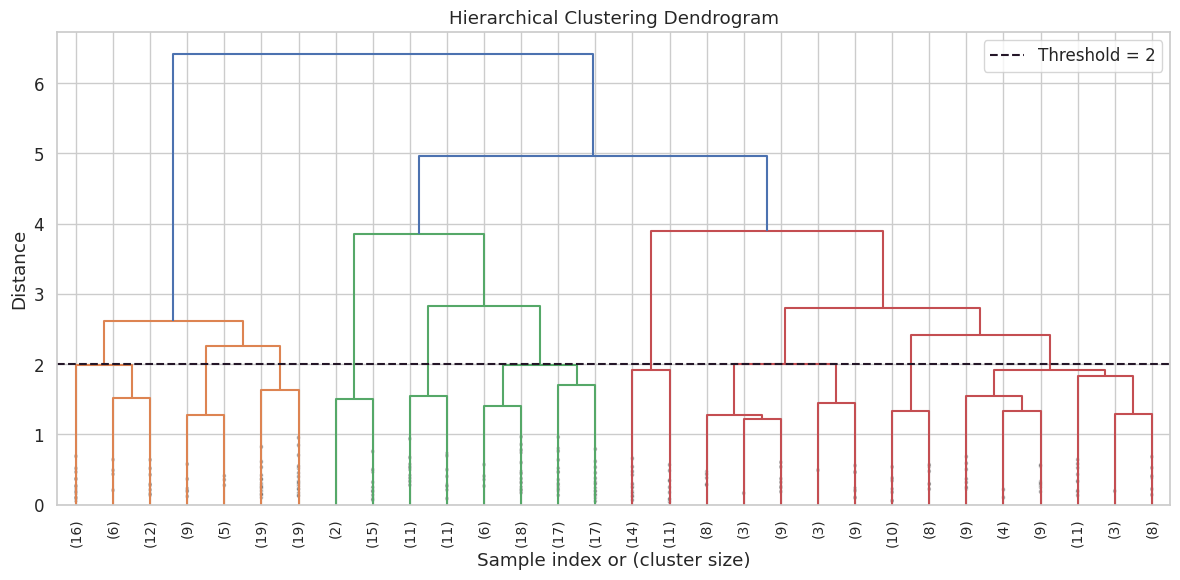

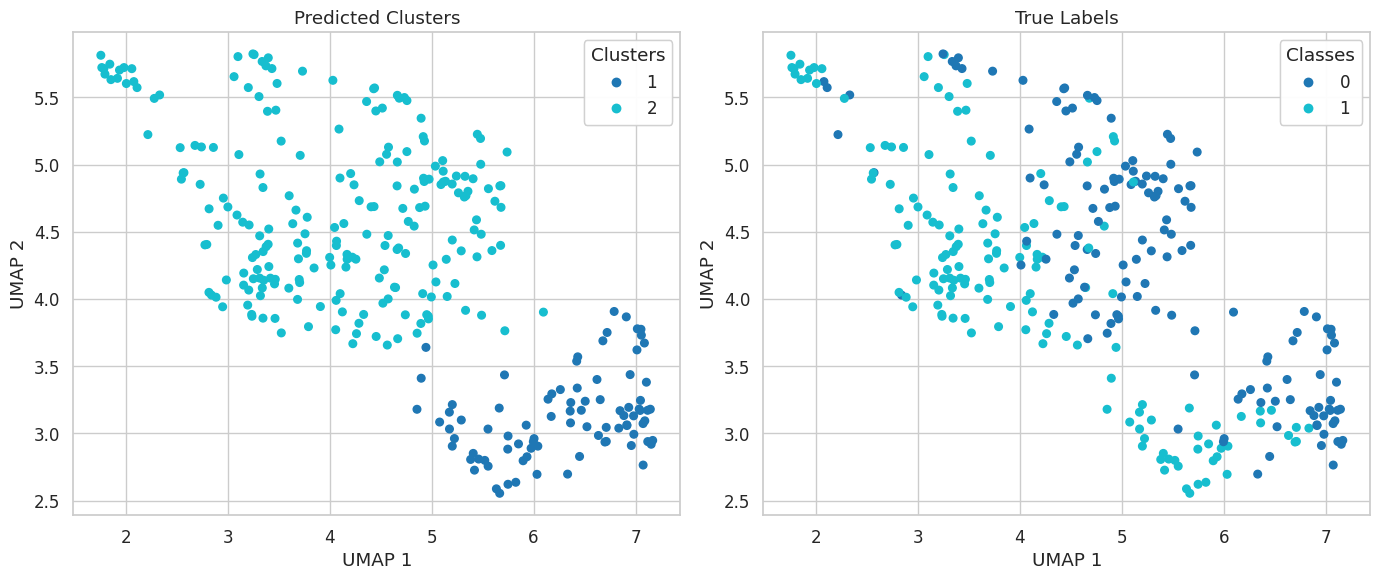

In [ ]:
# ------------------------ STEP 5: DENDROGRAM ------------------------
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.axhline(y=best_params['threshold'], color=dark_line, linestyle='--', label=f"Threshold = {best_params['threshold']}")
plt.legend()
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# ------------------------ STEP 6: CLUSTER SCATTERPLOTS ------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab10', s=30)
axs[0].set_title("Predicted Clusters")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
legend1 = axs[0].legend(*scatter1.legend_elements(), title="Clusters")
axs[0].add_artist(legend1)

#True labels
scatter2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y[idy].values, cmap='tab10', s=30)
axs[1].set_title("True Labels")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
legend2 = axs[1].legend(*scatter2.legend_elements(), title="Classes")
axs[1].add_artist(legend2)
plt.tight_layout()
plt.show()

## Final Comparison of Unsupervised Approaches:

In [ ]:
results_df = pd.DataFrame(clustering_results)
print(results_df.to_string(index=False))

      Method          Reduction  Silhouette   Calinski   Davies       ARI      NMI
      KMeans Variance Selection    0.812529 334.170510 0.851961 -0.001949 0.008042
Hierarchical Variance Selection    0.830527 156.222846 0.388099 -0.001651 0.028222
      KMeans                PCA    0.761277 416.128722 0.436074 -0.001949 0.008042
Hierarchical                PCA    0.761277 416.128722 0.436074 -0.001949 0.008042
      KMeans               UMAP    0.491037 351.893341 0.713807  0.006865 0.006396
Hierarchical               UMAP    0.497118 352.604401 0.693149  0.005618 0.005450


* All tested models showed good internal clustering metrics, which means that from a mathematical point of view, they managed to create groups that are quite cohesive and reasonably well separated. Metrics like Silhouette score, Calinski-Harabasz index, and Davies-Bouldin index give a clear idea of how good the clusters are structurally, and we can see that **hierarchical clustering** with **variance selection** performed best internally, having the highest Silhouette score and lowest Davies-Bouldin index. This tells us the clusters are compact and well defined for that method.

* When we look at external validation using the true labels, through ARI and NMI, all models show pretty low values. This suggests that despite the good internal separation, none of the methods really capture the real subtype structure very well. This gap between internal and external metrics highlights how challenging clustering can be when classes overlap or aren’t clearly separated.

* Additionally, both clustering methods using **UMAP** showed generally lower Silhouette scores, implying less compact and more overlapping clusters. Although the Calinski-Harabasz indices for UMAP clusters were moderate, they were still lower than those obtained with PCA or variance selection. Interestingly, UMAP methods presented slightly better ARI and NMI values compared to some other methods, but overall the external validation scores remained low, indicating a weak correspondence with the true labels.

* One interesting point is that both **K-Means** and **Hierarchical clustering** with PCA ended up with **exactly the same metrics**. This probably happened because PCA transformed the data so that both methods converged to very similar cluster assignments. By reducing the dimensionality and projecting the data onto components that explain most variance, PCA simplified the problem and made the difference between KMeans and Hierarchical clustering less noticeable.

* Looking at the dendrograms from all hierarchical clustering methods, there’s a clear pattern: they first split the data into **two main clusters**, then one of those clusters splits again into **two smaller subgroups**. This kind of structure suggests that there might be at least one meaningful subtype present.

Given this analysis, we assume hierarchical clustering combined with variance feature selection as the most suitable model, since it showed the best internal clustering quality and revealed meaningful cluster structures, despite the low correspondence with the true labels.



# Supervised Learning

In this stage, the goal was to build a binary classifier capable of distinguishing between the **Classical** (prognostically favorable) and **Mesenchymal** (prognostically adverse) subtypes. To achieve this, a structured pipeline was followed to ensure rigorous model evaluation, especially given the relatively small sample size.

First, the **data was split** using stratified **5-fold cross-validation**, ensuring that all steps, from preprocessing to feature selection, were performed only on the training folds and then applied to the test fold, avoiding any data leakage.

**Data preprocessing** involved scaling the features using StandardScaler and **feature selection** was then applied using the **ANOVA F-test**, selecting the 500 most informative features to reduce dimensionality and improve classifier performance.

Multiple machine learning models were trained, including Logistic Regression, SVM, Naive Bayes, Random Forest, and XGBoost, with different hyperparameter combinations tested via Grid Search. Model performance was evaluated using several metrics: accuracy, precision, recall, and F1-score, reporting the mean and standard deviation across the 5 folds.

In [ ]:
# models and their hyperparameter grids
models = {
    'LogisticRegression': {
        'classifier': LogisticRegression(max_iter=1000),
        'params': {'classifier__C': [0.1, 1, 10]}},
    'SVM': {
        'classifier': SVC(),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']}},
    'NaiveBayes': {
        'classifier': GaussianNB(),
        'params': {}},  # no hyperparameters to tune
    'RandomForest': {
        'classifier': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]}},
    'XGBoost': {
        'classifier': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6],
            'classifier__learning_rate': [0.1, 0.01]}}}

results = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1_micro': []} for name in models.keys()}


=================== FOLD 1 ===================
X_train_scaled shape: (241, 5000)
X_test_scaled shape: (61, 5000)
X_train_selected shape: (241, 500)
X_test_selected shape: (61, 500)


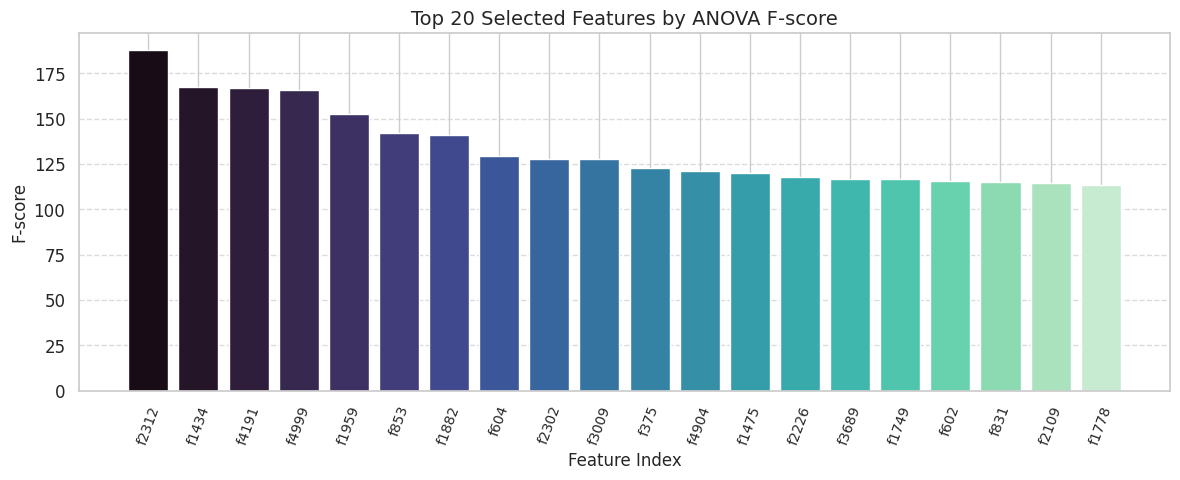

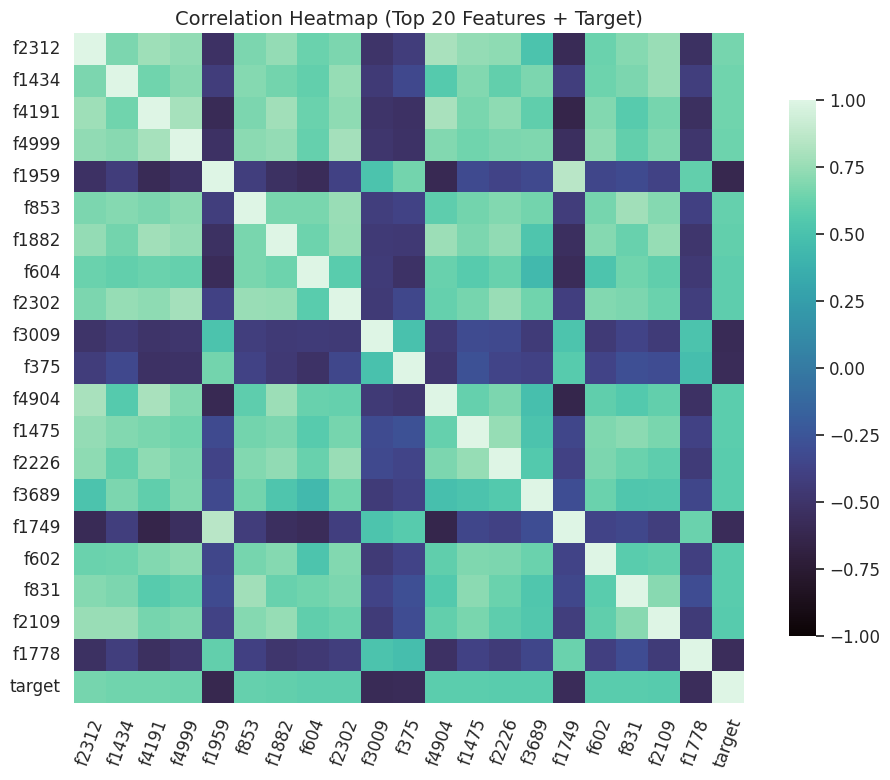


******************************

LogisticRegression - best params: {'classifier__C': 10}
LogisticRegression - accuracy: 0.8689, precision: 0.8689, recall: 0.8689, f1_micro: 0.8689

******************************

SVM - best params: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
SVM - accuracy: 0.9508, precision: 0.9508, recall: 0.9508, f1_micro: 0.9508

******************************

NaiveBayes - best params: {}
NaiveBayes - accuracy: 0.8852, precision: 0.8852, recall: 0.8852, f1_micro: 0.8852

******************************

RandomForest - best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
RandomForest - accuracy: 0.9180, precision: 0.9180, recall: 0.9180, f1_micro: 0.9180

******************************

XGBoost - best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
XGBoost - accuracy: 0.9016, precision: 0.9016, recall: 0.9016, f1_micro: 0.9016

=================== FOLD 2 ===================
X_tr

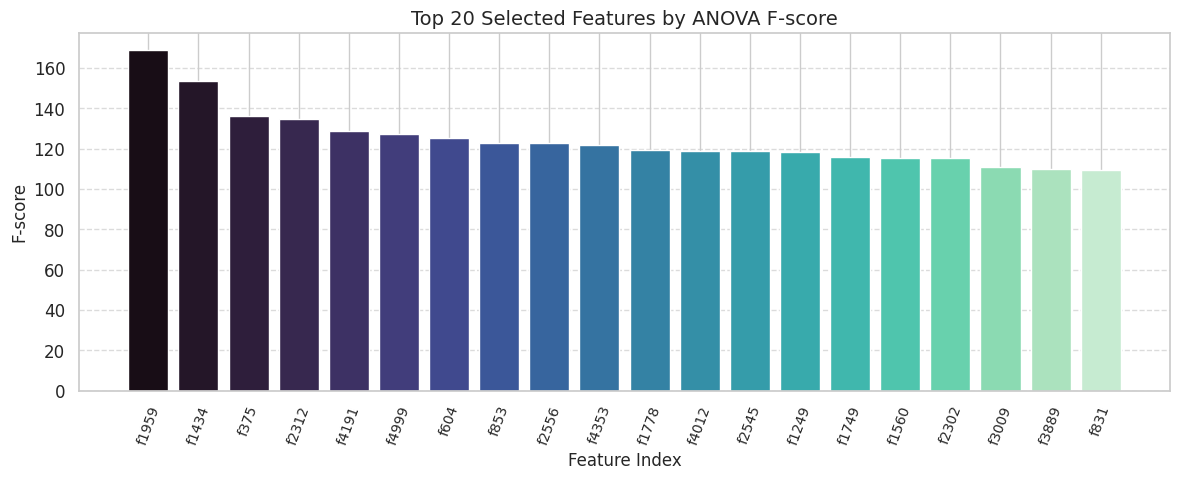

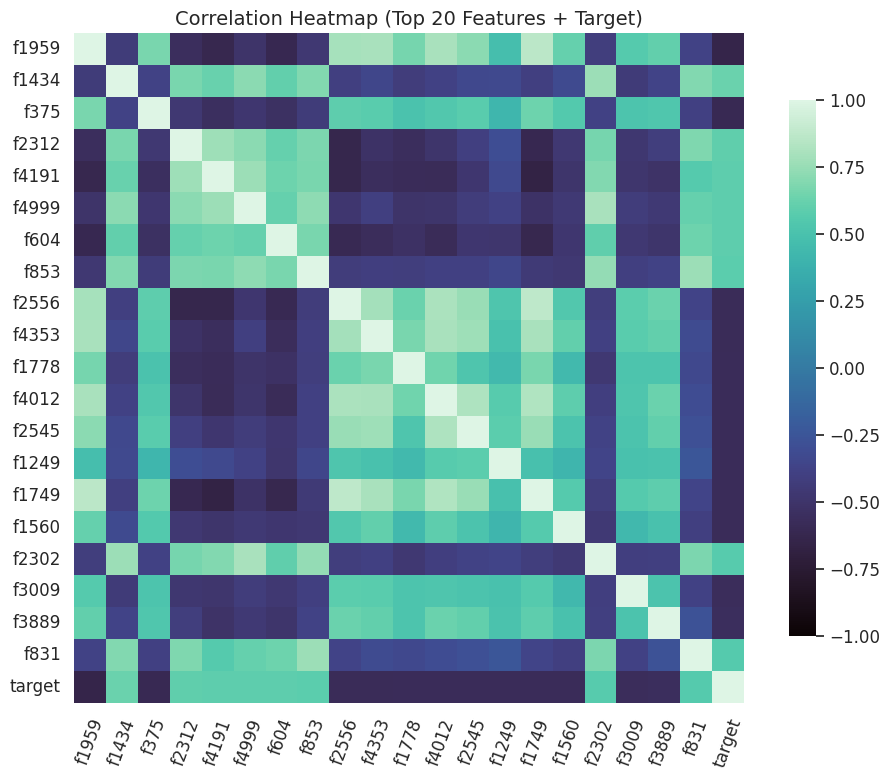


******************************

LogisticRegression - best params: {'classifier__C': 10}
LogisticRegression - accuracy: 0.9180, precision: 0.9180, recall: 0.9180, f1_micro: 0.9180

******************************

SVM - best params: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
SVM - accuracy: 0.9344, precision: 0.9344, recall: 0.9344, f1_micro: 0.9344

******************************

NaiveBayes - best params: {}
NaiveBayes - accuracy: 0.9508, precision: 0.9508, recall: 0.9508, f1_micro: 0.9508

******************************

RandomForest - best params: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
RandomForest - accuracy: 0.9344, precision: 0.9344, recall: 0.9344, f1_micro: 0.9344

******************************

XGBoost - best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
XGBoost - accuracy: 0.9180, precision: 0.9180, recall: 0.9180, f1_micro: 0.9180

=================== FOLD 3 ===================
X_trai

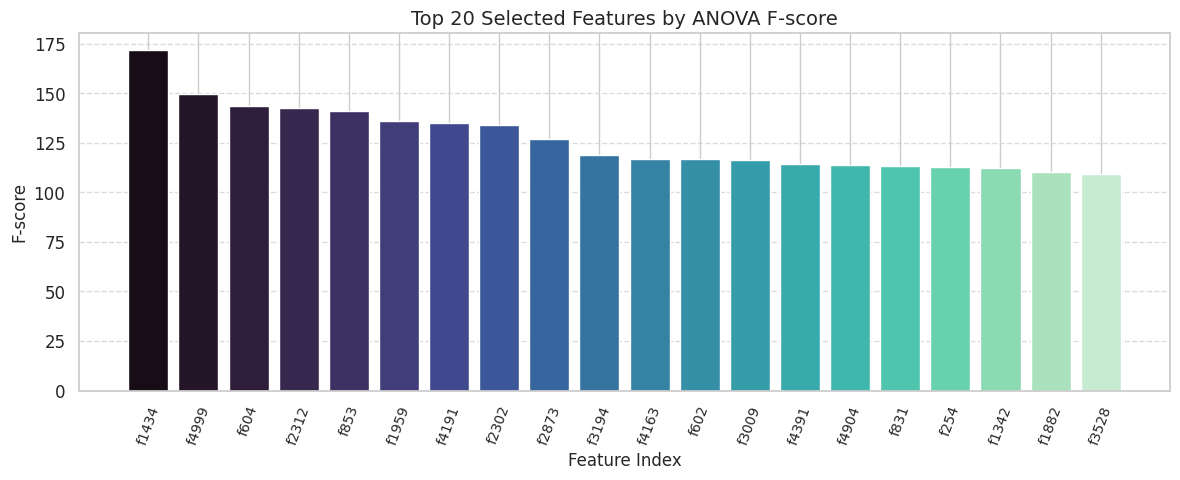

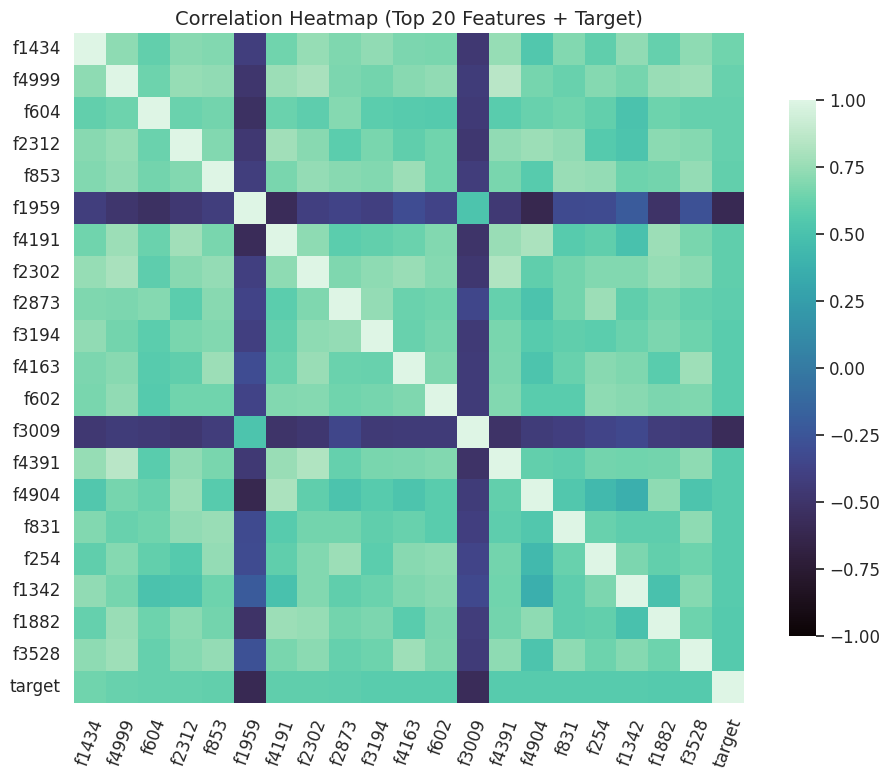


******************************

LogisticRegression - best params: {'classifier__C': 0.1}
LogisticRegression - accuracy: 0.9667, precision: 0.9667, recall: 0.9667, f1_micro: 0.9667

******************************

SVM - best params: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
SVM - accuracy: 0.9667, precision: 0.9667, recall: 0.9667, f1_micro: 0.9667

******************************

NaiveBayes - best params: {}
NaiveBayes - accuracy: 0.9333, precision: 0.9333, recall: 0.9333, f1_micro: 0.9333

******************************

RandomForest - best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
RandomForest - accuracy: 0.9833, precision: 0.9833, recall: 0.9833, f1_micro: 0.9833

******************************

XGBoost - best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
XGBoost - accuracy: 0.9500, precision: 0.9500, recall: 0.9500, f1_micro: 0.9500

=================== FOLD 4 ===================
X_t

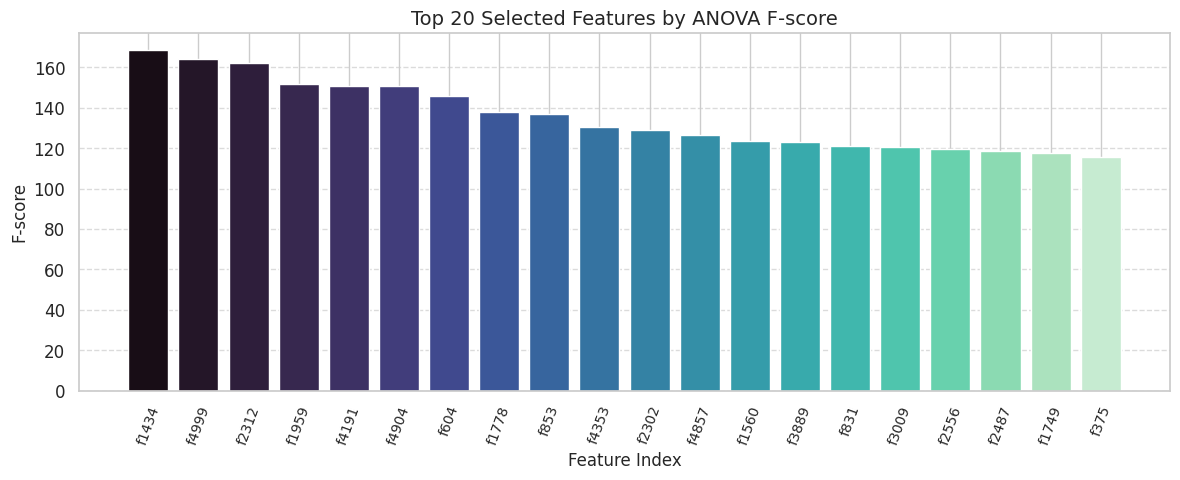

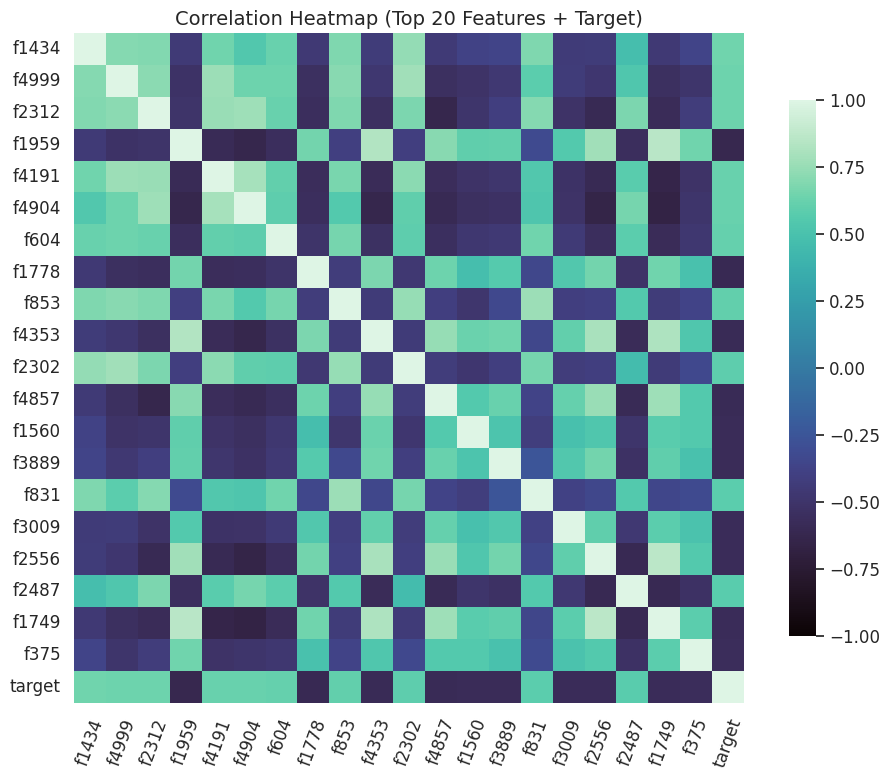


******************************

LogisticRegression - best params: {'classifier__C': 0.1}
LogisticRegression - accuracy: 0.8833, precision: 0.8833, recall: 0.8833, f1_micro: 0.8833

******************************

SVM - best params: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
SVM - accuracy: 0.9167, precision: 0.9167, recall: 0.9167, f1_micro: 0.9167

******************************

NaiveBayes - best params: {}
NaiveBayes - accuracy: 0.9167, precision: 0.9167, recall: 0.9167, f1_micro: 0.9167

******************************

RandomForest - best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
RandomForest - accuracy: 0.9000, precision: 0.9000, recall: 0.9000, f1_micro: 0.9000

******************************

XGBoost - best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}
XGBoost - accuracy: 0.8667, precision: 0.8667, recall: 0.8667, f1_micro: 0.8667

=================== FOLD 5 ===================
X_tr

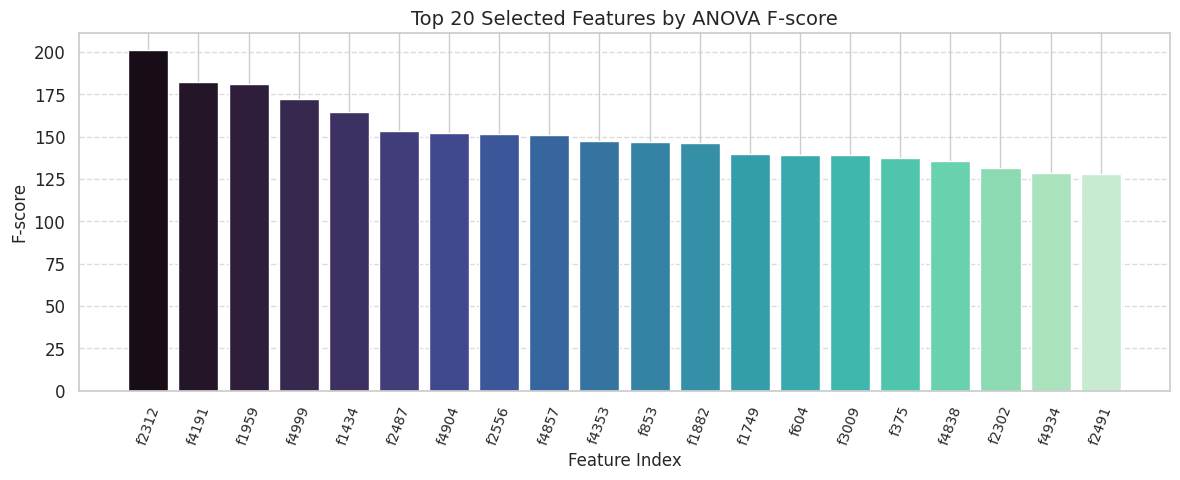

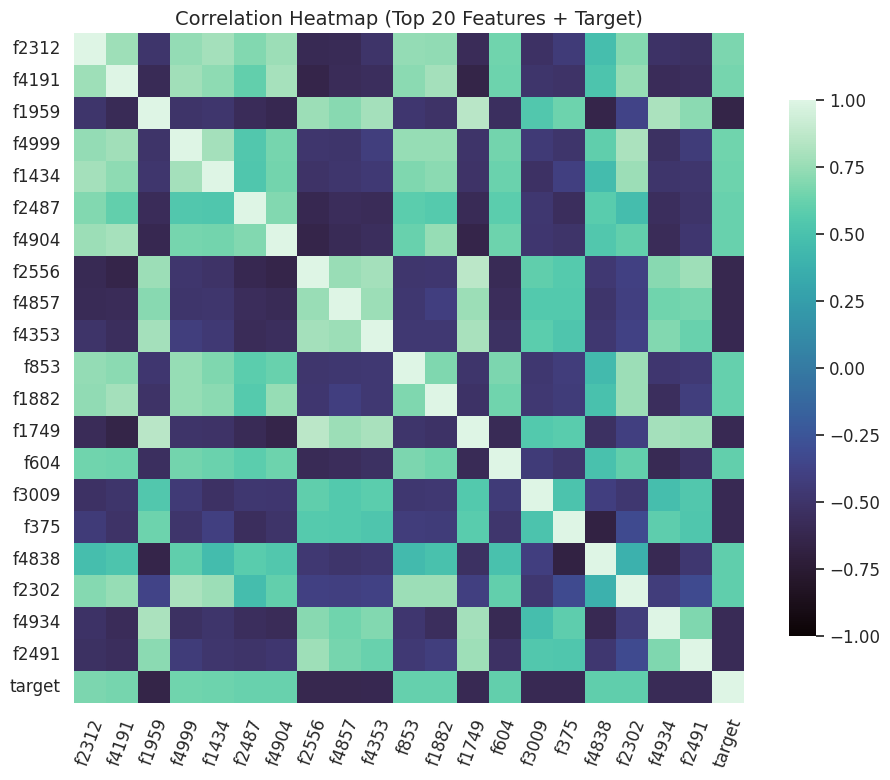


******************************

LogisticRegression - best params: {'classifier__C': 0.1}
LogisticRegression - accuracy: 0.9167, precision: 0.9167, recall: 0.9167, f1_micro: 0.9167

******************************

SVM - best params: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
SVM - accuracy: 0.8667, precision: 0.8667, recall: 0.8667, f1_micro: 0.8667

******************************

NaiveBayes - best params: {}
NaiveBayes - accuracy: 0.8500, precision: 0.8500, recall: 0.8500, f1_micro: 0.8500

******************************

RandomForest - best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
RandomForest - accuracy: 0.8833, precision: 0.8833, recall: 0.8833, f1_micro: 0.8833

******************************

XGBoost - best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
XGBoost - accuracy: 0.8500, precision: 0.8500, recall: 0.8500, f1_micro: 0.8500


In [ ]:
# ======================== STEP 0: SHUFFLE DATA ========================
X, labels = shuffle(X, labels, random_state=42)

# StratifiedKFold with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ======================== CROSS-VALIDATION LOOP ========================
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, labels)):
    print(f"\n=================== FOLD {fold_idx + 1} ===================")

    # ------------------------ STEP 1: SPLIT DATA ------------------------
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # ------------------------ STEP 2: SCALE DATA ------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # fit + transform on train
    X_test_scaled = scaler.transform(X_test)        # transform on test only

    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")

    # ------------------------ STEP 3: FEATURE SELECTION ------------------------
    selector = SelectKBest(score_func=f_classif, k=500)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    print(f"X_train_selected shape: {X_train_selected.shape}")
    print(f"X_test_selected shape: {X_test_selected.shape}")

    # visualize top 20 selected features by f-score
    f_scores = selector.scores_
    selected_indices = selector.get_support(indices=True)
    selected_scores = f_scores[selected_indices]

    # get indices of top 20 features sorted by score (descending)
    top_20_idx = np.argsort(selected_scores)[-20:][::-1]

    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(20), selected_scores[top_20_idx], color=sns.color_palette("mako", 20))
    plt.xticks(range(20), [f"f{selected_indices[i]}" for i in top_20_idx], rotation=70, fontsize=10)
    plt.title("Top 20 Selected Features by ANOVA F-score", fontsize=14)
    plt.ylabel("F-score", fontsize=12)
    plt.xlabel("Feature Index", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # correlation matrix of top 20 (features + target)
    top_20_features_train = X_train_selected[:, top_20_idx]
    data_with_target = np.column_stack([top_20_features_train, y_train])
    corr_matrix = np.corrcoef(data_with_target, rowvar=False)
    heatmap_labels = [f"f{selected_indices[i]}" for i in top_20_idx] + ["target"]


    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="mako", vmin=-1, vmax=1, cbar_kws={"shrink": 0.8}, square=True, xticklabels=heatmap_labels, yticklabels=heatmap_labels)
    plt.title("Correlation Heatmap (Top 20 Features + Target)", fontsize=14)
    plt.xticks(rotation=70)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


    # ========================= GRID SEARCH for each model =========================
    for name, config in models.items():
        print(f"\n{'*'*30}\n")
        pipe = Pipeline([('classifier', config['classifier'])])
        param_grid = config['params']

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring='f1_micro',
            cv=3,
            n_jobs=-1,
            verbose=0,
            refit=True)

        # ------------------------ STEP 4: MODEL TRAINING ------------------------

        # fit on transformed train data only
        grid.fit(X_train_selected, y_train)
        best_model = grid.best_estimator_

        # predict on transformed test data
        y_pred = best_model.predict(X_test_selected)

        # calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='micro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)

        results[name]['accuracy'].append(acc)
        results[name]['precision'].append(prec)
        results[name]['recall'].append(rec)
        results[name]['f1_micro'].append(f1)

        print(f"{name} - best params: {grid.best_params_}")
        print(f"{name} - accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1_micro: {f1:.4f}")

## Final Comparison of Unsupervised Approaches:

In [ ]:
print("\n\n=== Final Results Summary ===")
for name, metrics in results.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    for metric_name, scores in metrics.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{metric_name}: {mean_score:.4f} ± {std_score:.4f}")



=== Final Results Summary ===

LogisticRegression
accuracy: 0.9107 ± 0.0338
precision: 0.9107 ± 0.0338
recall: 0.9107 ± 0.0338
f1_micro: 0.9107 ± 0.0338

SVM
accuracy: 0.9270 ± 0.0345
precision: 0.9270 ± 0.0345
recall: 0.9270 ± 0.0345
f1_micro: 0.9270 ± 0.0345

NaiveBayes
accuracy: 0.9072 ± 0.0359
precision: 0.9072 ± 0.0359
recall: 0.9072 ± 0.0359
f1_micro: 0.9072 ± 0.0359

RandomForest
accuracy: 0.9238 ± 0.0343
precision: 0.9238 ± 0.0343
recall: 0.9238 ± 0.0343
f1_micro: 0.9238 ± 0.0343

XGBoost
accuracy: 0.8973 ± 0.0358
precision: 0.8973 ± 0.0358
recall: 0.8973 ± 0.0358
f1_micro: 0.8973 ± 0.0358


Among all classifiers tested, the **Support Vector Machine** (SVM) consistently delivered the best performance across all metrics. In every fold of the cross-validation, the model selected by grid search was the SVM with an **RBF kernel**, suggesting that this non-linear decision boundary was best suited for the complexity of the gene expression data. This model demonstrated a strong ability to differentiate between the Classical and Mesenchymal subtypes.

Random Forest followed closely behind, with very competitive results, while Logistic Regression and Naive Bayes also showed solid and stable performance. Although XGBoost was slightly behind in all metrics, it still maintained a respectable level of accuracy, indicating that all models were able to capture meaningful patterns in the data.

Additionally, the correlation matrix built using the top 20 features selected by ANOVA F-score revealed that some of these features showed strong correlation with the target label. This supports the biological relevance of the selected features and reinforces their value in the classification task.